# Test

In [3]:
import numpy as np
import pandas as pd
import os
import torch
import pickle
import math
import matplotlib.pyplot as plt
import sys
sys.path.append('/data/wangchen/instance_centric/instance_centric_model/')
from parser_args import get_parser
from src.model import Model

## function

### handle batch

In [4]:
def prepare_batch(batch_list):
    batch_size = len(batch_list)
    key_to_list = {}
    for key in batch_list[0].keys():
        key_to_list[key] = [batch_list[bs_idx][key] for bs_idx in range(batch_size)]

    input_dict = {}
    for key, val_list in key_to_list.items():
        val_list = [torch.from_numpy(x) for x in val_list]
        if key in ['agent_feats', 'agent_mask', 'agent_ctrs', 'agent_vecs', 'gt_preds',
                    'plan_feat', 'plan_mask', 'map_ctrs', 'map_vecs', 'map_feats', 'map_mask']:
            input_dict[key] = merge_batch_1d(val_list).to('cuda')
        elif key in ['candidate_mask', 'gt_candts', 'rpe', 'rpe_mask']:
            input_dict[key] = merge_batch_2d(val_list).to('cuda')
        elif key in ['candidate_refpaths_cords', 'candidate_refpaths_vecs']:
            input_dict[key] = merge_batch_2d_more(val_list).to('cuda')
        else:
            print(key)
            continue
    return input_dict

def merge_batch_1d(tensor_list):
    assert len(tensor_list[0].shape) in [2, 3]
    only_2d_tensor = False
    if len(tensor_list[0].shape) == 2:
        tensor_list = [x.unsqueeze(dim=-1) for x in tensor_list]
        only_2d_tensor = True
    tensor_list = [x.unsqueeze(dim=0) for x in tensor_list]
    max_feat0 = max([x.shape[1] for x in tensor_list])
    _, _, num_feat1, num_feat2 = tensor_list[0].shape
    ret_tensor_list = []
    for k in range(len(tensor_list)):
        cur_tensor = tensor_list[k]
        assert cur_tensor.shape[2] == num_feat1 and cur_tensor.shape[3] == num_feat2

        new_tensor = cur_tensor.new_zeros(cur_tensor.shape[0], max_feat0, num_feat1, num_feat2)
        new_tensor[:, :cur_tensor.shape[1], :, :] = cur_tensor
        ret_tensor_list.append(new_tensor)

    ret_tensor = torch.cat(ret_tensor_list, dim=0)  # (num_stacked_samples, num_feat0_maxt, num_feat1, num_feat2)
    if only_2d_tensor:
        ret_tensor = ret_tensor.squeeze(dim=-1)
    return ret_tensor

def merge_batch_2d(tensor_list):
    assert len(tensor_list[0].shape) in [2, 3]
    only_2d_tensor = False
    if len(tensor_list[0].shape) == 2:
        tensor_list = [x.unsqueeze(dim=-1) for x in tensor_list]
        only_2d_tensor = True
    tensor_list = [x.unsqueeze(dim=0) for x in tensor_list]
    max_feat0 = max([x.shape[1] for x in tensor_list])
    max_feat1 = max([x.shape[2] for x in tensor_list])

    num_feat2 = tensor_list[0].shape[-1]
    ret_tensor_list = []
    for k in range(len(tensor_list)):
        cur_tensor = tensor_list[k]
        new_tensor = cur_tensor.new_zeros(cur_tensor.shape[0], max_feat0, max_feat1, num_feat2)
        new_tensor[:, :cur_tensor.shape[1], :cur_tensor.shape[2], :] = cur_tensor
        ret_tensor_list.append(new_tensor)

    ret_tensor = torch.cat(ret_tensor_list, dim=0)  # (num_stacked_samples, num_feat0_maxt, num_feat1_maxt, num_feat2)
    if only_2d_tensor:
        ret_tensor = ret_tensor.squeeze(dim=-1)
    return ret_tensor

def merge_batch_2d_more( tensor_list):
    assert len(tensor_list[0].shape) == 4
    tensor_list = [x.unsqueeze(dim=0) for x in tensor_list] # list[1, all_n, Max-N, 20, 2]
    max_feat0 = max([x.shape[1] for x in tensor_list]) # all_n-Max
    max_feat1 = max([x.shape[2] for x in tensor_list]) # Max-N-Max
    num_feat2 = tensor_list[0].shape[3] # 20
    num_feat3 = tensor_list[0].shape[4] # 2
    ret_tensor_list = []

    for k in range(len(tensor_list)):
        cur_tensor = tensor_list[k]
        new_tensor = cur_tensor.new_zeros(cur_tensor.shape[0], max_feat0, max_feat1, num_feat2, num_feat3) # 1, all_n-Max, Max-N-Max, 2
        new_tensor[:, :cur_tensor.shape[1], :cur_tensor.shape[2], :, :] = cur_tensor
        ret_tensor_list.append(new_tensor)

    ret_tensor = torch.cat(ret_tensor_list, dim=0)  # bs,all_n-Max, Max-N-Max, 20, 2
    return ret_tensor


### plot 

In [25]:
def transform_to_ori(feat, ctr, vec):
    if not isinstance(feat, np.ndarray):
        feat = feat.detach().cpu().numpy()
    if not isinstance(ctr, np.ndarray):
        ctr = ctr.detach().cpu().numpy()
    if not isinstance(vec, np.ndarray):
        vec = vec.detach().cpu().numpy()
    cos_, sin_ = vec
    rot = np.asarray([[sin_, cos_], [-cos_, sin_]])
    rot_inv = rot.T
    feat[:, 0:2] = np.matmul(feat[:, 0:2], rot_inv) + ctr
    return feat

def calculate_box_corners(x, y, yaw, length, width):
    x += length*0.295*math.cos(yaw)
    y += length*0.295*math.sin(yaw)
    half_length = length/2
    half_width = width/2
    corner_xs, corner_ys = [], []
    # right head
    corner_xs.append(x + half_length * math.cos(yaw) + half_width * math.cos(yaw - 0.5*math.pi))
    corner_ys.append(y + half_length * math.sin(yaw) + half_width * math.sin(yaw - 0.5*math.pi))
    # left head
    corner_xs.append(x + half_length * math.cos(yaw) + half_width * math.cos(yaw + 0.5*math.pi))
    corner_ys.append(y + half_length * math.sin(yaw) + half_width * math.sin(yaw + 0.5*math.pi))
    # left tail
    corner_xs.append(x + half_length * math.cos(yaw + math.pi) + half_width * math.cos(yaw + 0.5*math.pi))
    corner_ys.append(y + half_length * math.sin(yaw + math.pi) + half_width * math.sin(yaw + 0.5*math.pi))
    # right tail
    corner_xs.append(x + half_length * math.cos(yaw + math.pi) + half_width * math.cos(yaw - 0.5*math.pi))
    corner_ys.append(y + half_length * math.sin(yaw + math.pi) + half_width * math.sin(yaw - 0.5*math.pi))

    corner_xs.append(corner_xs[0])
    corner_ys.append(corner_ys[0])
    return corner_xs, corner_ys

def select_top_n(ax, pred_trajs, candidate_refpaths,pred_probs, top_n=1):# M,50，2 +  M,20,2,  + M
    '''
    用于选出前几个的轨迹，返回轨迹、轨迹信息、也即对应的refpath
    '''
    
    valid_pred_probs_len = (pred_probs > 0.001).sum() # 得到有效的prob个数
    top_n = min(top_n, valid_pred_probs_len)
    max_scores_indices = pred_probs.argsort()[::-1][:top_n] # S，     获取prob排名前S个的idx
    
    scores = pred_probs[max_scores_indices]# S
    max_pred_trajs = pred_trajs[max_scores_indices,:, :] # S,50,2
    max_pred_refpath = candidate_refpaths[max_scores_indices,:,:] # S, 20, 2
    
    # score_sum = sum(scores)# top n的概率进行重分配
    # acc_prob = 0 # 用作终止条件
    # prob_info = ''
    # traj_index = 0
    # while traj_index < max_pred_trajs.shape[0]:# 对前S个进行概率
    #     prob = scores[traj_index]
    #     prob_info += f'traj_{traj_index}:{str(round(prob/score_sum, 3))}, '
    #     traj_index += 1
    #     acc_prob += prob/score_sum
    #     if acc_prob > 0.75:
    #         break
    prob_info = ''
    for i in range(top_n):
        prob_info += f"traj_{i}'s prob={str(round(scores[i], 2))}, "
        
        
    # return max_pred_trajs[:traj_index], prob_info # s,50,2
    return max_pred_trajs, max_pred_refpath, prob_info # s,50,2

def plot_case(input_dict, output_dict, save_path=None):
    # 仅取batch中的一个sample
    # input 
    agent_feats = input_dict['agent_feats'][0]# all_n, 20, 13
    agent_mask = input_dict['agent_mask'][0] # all_n, 20
    agent_ctrs = input_dict['agent_ctrs'][0] # all_n, 2
    agent_vecs = input_dict['agent_vecs'][0] # all_n, 2
    
    map_feats = input_dict['map_feats'][0]# men, 20, 5
    map_mask = input_dict['map_mask'][0]# men, 20
    map_ctrs = input_dict['map_ctrs'][0]
    map_vecs = input_dict['map_vecs'][0]
    
    gt_preds = input_dict['gt_preds'][0] # all_n, 50, 2
    candidate_refpaths_cords = input_dict['candidate_refpaths_cords'][0].detach().cpu().numpy() # all_n, M, 20, 2
    
    gt_candt_refpath = input_dict['gt_candts'][0].detach().cpu().numpy()# all_n, M
    gt_candt_idx = np.argmax(gt_candt_refpath, axis= 1) # all_n
    
    candiate_mask = input_dict['candidate_mask'][0] # all_n, M
    pred_mask = candiate_mask.sum(dim=-1) > 0 # all_n  是否存在候选 path
    
    # output
    pred_trajs = output_dict['trajs'][0].detach().cpu().numpy() # all_n,M,50,2
    pred_traj_with_gt = output_dict['traj_with_gt'][0].detach().cpu().numpy() # all_n,1,50,2
    pred_probs = output_dict['traj_probs'][0].detach().cpu().numpy() # all_n, M
    

    fig, ax = plt.subplots(figsize=(28,16))
    ax.axis("equal")
    min_width, min_height = 1e8, 1e8
    max_width, max_height = -1, -1

    
    for i in range(map_feats.shape[0]): # 画出周围地图信息
        line_info = transform_to_ori(map_feats[i][map_mask[i].bool()], map_ctrs[i], map_vecs[i])# 20,5 + 2 + 2
        ax.plot(line_info[:, 0], line_info[:, 1], color='y', linewidth=0.5)
        min_width = min(min(line_info[:, 0]), min_width)
        max_width = max(max(line_info[:, 0]), max_width)
        min_height = min(min(line_info[:, 1]), min_height)
        max_height = max(max(line_info[:, 1]), max_height)

    
    for i in range(pred_mask.shape[0]): # 画出每一个障碍物信息
        traj_info = transform_to_ori(agent_feats[i][agent_mask[i].bool()], agent_ctrs[i], agent_vecs[i])# [s,13] + 2 + 2 -> [s,2]
        min_width = min(min(traj_info[:, 0]), min_width)
        max_width = max(max(traj_info[:, 0]), max_width)
        min_height = min(min(traj_info[:, 1]), min_height)
        max_height = max(max(traj_info[:, 1]), max_height)
        ax.plot(traj_info[:, 0], traj_info[:, 1], color='tan', linewidth=1.0)# 所有历史轨迹画棕色
        marker = '.'
        color = 'g'
        if pred_mask[i]:# pred_mask判断该agent是否是目标障碍物
            marker = '*'
            color = 'b'
            # 画出一个障碍物对应的s条预测轨迹
            top_trajs, top_refpaths, prob_info = select_top_n(ax, pred_trajs[i], candidate_refpaths_cords[i], pred_probs[i], top_n=4) # M, 50，2 + M -> s, 50, 2 
            ax.text(0.01, 0.95 - i*0.05, f"agent-{i}: {prob_info}", transform=ax.transAxes)
            for j in range(top_trajs.shape[0]): # s条预测轨迹
                top_traj = transform_to_ori(top_trajs[j], agent_ctrs[i], agent_vecs[i])
                top_refpath = transform_to_ori(top_refpaths[j], agent_ctrs[i], agent_vecs[i])
                pred_color = 'salmon'
                if j == 0:
                    pred_color = 'r'
                # ax.text(top_traj[0,0], top_traj[0,1], f"{j}'s", color=pred_color)    
                ax.plot(top_traj[:, 0], top_traj[:, 1], color=pred_color, linewidth=1.0, alpha=0.5)# 预测轨迹
                if j == gt_candt_idx[i]:
                    ax.plot(top_refpath[:,0], top_refpath[:, 1], color = 'green', marker='+', linewidth = 1.0, alpha= 0.6) # 对应的候选ref path
                else:
                    ax.plot(top_refpath[:,0], top_refpath[:, 1], color = 'green', linewidth = 1.0, alpha= 0.6) # 对应的候选ref path
                    
                # ax.text(top_traj[-1,0], top_traj[-1,1], f"{j}'e", color=pred_color)    
            
            
            gt_pred = transform_to_ori(gt_preds[i], agent_ctrs[i], agent_vecs[i]) 
            # ax.plot(gt_pred[:, 0], gt_pred[:, 1], color='green', linewidth=1.0, alpha=0.8) # 画出真值轨迹
        elif i==0:
            # ego
            marker = '*'
            color = 'r' 
            
        ax.plot(traj_info[-1, 0], traj_info[-1, 1], marker=marker, markersize=8, color=color) # 画出观测点
        length, width = traj_info[-1, 4], traj_info[-1, 5]
        theta = math.atan2(agent_vecs[i][1], agent_vecs[i][0])
        # 画出车头    自车用红色
        corner_xs, corner_ys = calculate_box_corners(traj_info[-1, 0], traj_info[-1, 1], theta, length, width)
        ax.plot(corner_xs, corner_ys, color=color, linewidth=1.0)
        ax.text(corner_xs[0]+0.5,corner_ys[0]+0.5,f"agent-{i}", color=color)
    roi_matrix = [min_width, max_width, min_height, max_height]
    ax.axis(roi_matrix) 
    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path, dpi=250)
        plt.close()
    return

### secondary

In [26]:
def get_model_output(index):
    pickle_path = input_dir + file_names[index]
    print("pickle_path:",pickle_path)
    with open(pickle_path, 'rb') as f:
        data_dict = pickle.load(f)
    input_dict = prepare_batch([data_dict]) 
    
    print("=="*100)
    print(input_dict['agent_ctrs'].device)
    print(model.device)
    output_dict = model(input_dict)
    return input_dict, output_dict

## main

In [27]:
# 加载模型
model_path = '/data/wangchen/instance_centric/instance_centric_model/output/MODEL/train_20240513/MODEL_best_model.pt'
parser = get_parser()
args = parser.parse_args([])
model = Model(args).cuda(0)
device = torch.device('cuda:0')
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
input_dir = '/private/wangchen/instance_model/instance_model_data/test/'
file_names = os.listdir(input_dir)
print("file num:", len(file_names))
output_dir = '/data/wangchen/plot_instance/'
os.makedirs(output_dir, exist_ok=True)

file num: 247649


pickle_path: /private/wangchen/instance_model/instance_model_data/test/howo32_1683498380.743353.pkl
cuda:0
cuda


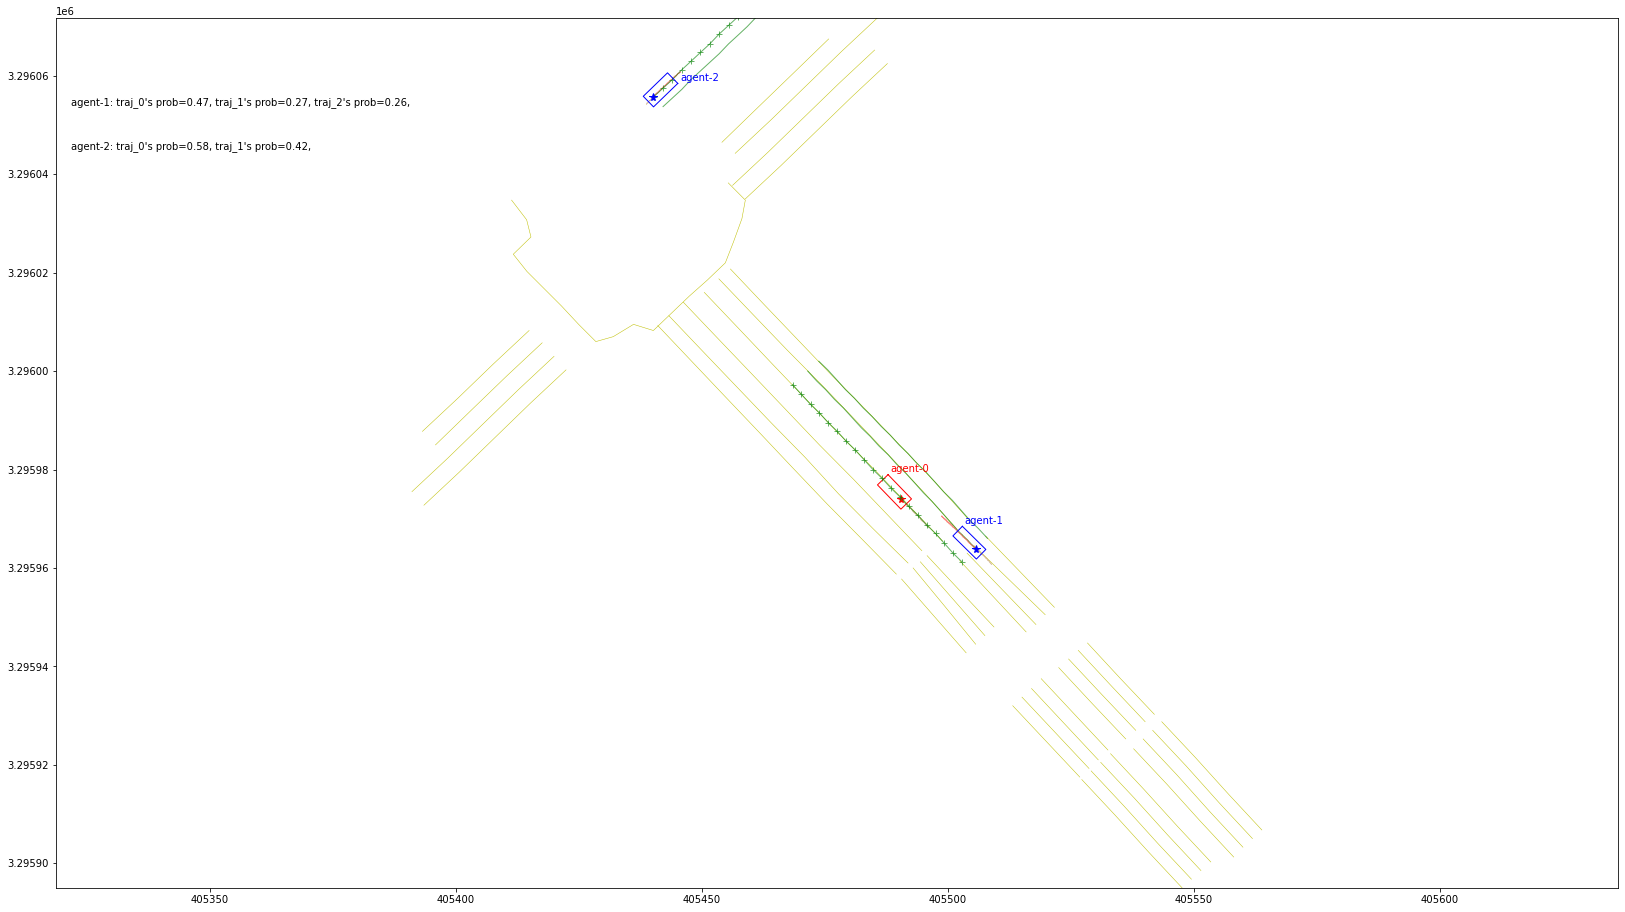

In [28]:
index = 6
    # for i in range(len(data['inter_info'])):
        
    # for i in range(len(data['inter_info'])):
        
    # for i in range(len(data['inter_info'])):
        
    # for i in range(len(data['inter_info'])):
    
        
    # for i in range(len(data['inter_info'])):
        
input_dict, output_dict = get_model_output(index)
plot_case(input_dict, output_dict)

In [32]:
agent_feats = input_dict['agent_feats'][0]
agent_mask = input_dict['agent_mask'][0]
agent_ctrs = input_dict['agent_ctrs'][0]
agent_vecs = input_dict['agent_vecs'][0]
map_feats = input_dict['map_feats'][0]
map_mask = input_dict['map_mask'][0]
map_ctrs = input_dict['map_ctrs'][0]
map_vecs = input_dict['map_vecs'][0]
gt_preds = input_dict['gt_preds'][0]
pred_trajs = output_dict['trajs'][0].detach().cpu().numpy()
pred_probs = output_dict['traj_probs'][0].detach().cpu().numpy()
candiate_mask = input_dict['candidate_mask'][0]
pred_mask = candiate_mask.sum(dim=-1) > 0

In [33]:
agent_feats[1][:, 2]

tensor([5.5089, 5.5404, 5.4947, 5.4521, 5.6626, 5.8740, 6.1250, 6.2891, 6.3319,
        6.3157, 6.2876, 6.1593, 6.0605, 5.9215, 5.7695, 5.5069, 5.4002, 5.2905,
        5.2286, 5.3263], device='cuda:0')

In [ ]:
agent_mask[1]

In [11]:
# input
agent_feats = input_dict['agent_feats'][0]# all_n, 20, 13
agent_mask = input_dict['agent_mask'][0] # all_n, 20
agent_ctrs = input_dict['agent_ctrs'][0] # all_n, 2
agent_vecs = input_dict['agent_vecs'][0] # all_n, 2

map_feats = input_dict['map_feats'][0]# men, 20, 5
map_mask = input_dict['map_mask'][0]# men, 20
map_ctrs = input_dict['map_ctrs'][0]
map_vecs = input_dict['map_vecs'][0]

gt_preds = input_dict['gt_preds'][0] # all_n, 50, 2
candidate_refpaths_cords = input_dict['candidate_refpaths_cords'][0].detach().cpu().numpy() # all_n, M, 20, 2
candiate_mask = input_dict['candidate_mask'][0] # all_n, M
pred_mask = candiate_mask.sum(dim=-1) > 0 # all_n  是否存在候选 path

# output
pred_trajs = output_dict['trajs'][0].detach().cpu().numpy() # all_n,M,50,2
pred_probs = output_dict['traj_probs'][0].detach().cpu().numpy() # all_n, M

In [12]:
pred_mask

tensor([False,  True,  True], device='cuda:0')